=== ML CV Results (mean over folds) ===
GaussianNB: Acc=0.759, Prec=0.117, Rec=0.659, F1=0.199
KNN: Acc=0.860, Prec=0.142, Rec=0.403, F1=0.209
MLP: Acc=0.918, Prec=0.168, Rec=0.208, F1=0.185
RandomForest: Acc=0.955, Prec=0.467, Rec=0.073, F1=0.121
SVM: Acc=0.786, Prec=0.113, Rec=0.547, F1=0.188

=== DL CV Results (mean over folds) ===
CNN+Transformer: Acc=0.892, Prec=0.137, Rec=0.255, F1=0.177
HNN: Acc=0.888, Prec=0.166, Rec=0.354, F1=0.225

Final model accuracies on held-out test set:
RandomForest: Acc = 0.961
SVM: Acc = 0.773
KNN: Acc = 0.862
MLP: Acc = 0.939
GaussianNB: Acc = 0.768
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
HNN final acc: 0.909
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
CNN+Transformer final acc: 0.890

--- SHAP for RandomForest ---
Explainer: TreeExplainer (exact SHAP for tree models). Background: model trees (no separate background needed).


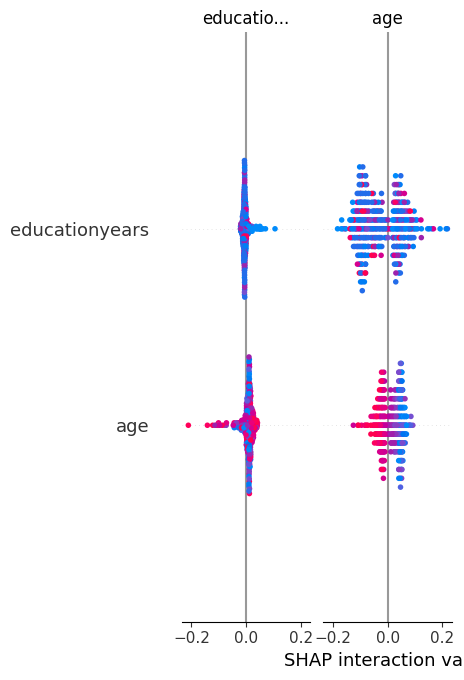

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
# =============================================================================
# Full dementia pipeline (Gaussian augmentation CV) + SHAP explainability (final models)
# =============================================================================

import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, Input
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add, Flatten

# --------------------------
# Load dataset (user path)
# --------------------------
df = pd.read_csv("/content/drive/MyDrive/kawser/dataset_dementia (1) (1).csv")
df = df.dropna(subset=["dementia"])  # drop rows missing target

# Feature lists (adjust to your dataset)
num_features = ["age", "educationyears", "EF", "PS", "Global"]
cat_ohe_features = ["gender", "diabetes", "hypertension", "hypercholesterolemia"]
cat_label_features = ["smoking"]

# Keep only present cols
X_all = df.drop("dementia", axis=1).copy()
y_all = df["dementia"].astype(int).values

num_features = [c for c in num_features if c in X_all.columns]
cat_ohe_features = [c for c in cat_ohe_features if c in X_all.columns]
cat_label_features = [c for c in cat_label_features if c in X_all.columns]

# --------------------------
# Helper: Gaussian augmentation (your version)
# --------------------------
def gaussian_augment(X, y, noise_std=0.01, factor=1.0):
    """Augments minority classes using Gaussian noise to balance towards the majority class."""
    classes, counts = np.unique(y, return_counts=True)
    max_count = counts.max()
    X_aug = [X]
    y_aug = [y]
    for cls, cnt in zip(classes, counts):
        cls_idx = np.where(y == cls)[0]
        n_needed = int((max_count - cnt) * factor)
        if n_needed > 0 and len(cls_idx) > 0:
            samples = X[cls_idx]
            noise = np.random.normal(0, noise_std, size=(n_needed, X.shape[1]))
            synthetic = samples[np.random.choice(len(samples), n_needed, replace=True)] + noise
            X_aug.append(synthetic)
            y_aug.append(np.full(n_needed, cls))
    return np.vstack(X_aug), np.hstack(y_aug)

# --------------------------
# Model builders for DL
# --------------------------
def build_hnn(input_dim):
    model = models.Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_cnn_transformer(input_dim):
    inputs = Input(shape=(input_dim,1))
    x = Conv1D(64, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = LayerNormalization()(x)
    attn_output = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = Add()([x, attn_output])
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation="relu")(x)
    outputs = Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# --------------------------
# === STEP A: Cross-validated ML/DL training (keeps your workflow)
# --------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ml_models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GaussianNB": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=42)
}

results_ml = []
oof_preds = {name: np.zeros(len(y_all), dtype=int) for name in ml_models.keys()}
results_dl = []
oof_preds_dl = {"HNN": np.zeros(len(y_all), dtype=int), "CNN+Transformer": np.zeros(len(y_all), dtype=int)}

for fold, (train_idx, test_idx) in enumerate(skf.split(X_all, y_all)):
    X_train_df, X_test_df = X_all.iloc[train_idx].copy(), X_all.iloc[test_idx].copy()
    y_train, y_test = y_all[train_idx], y_all[test_idx]

    # Numeric impute + scale
    num_imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()
    X_train_num = num_imputer.fit_transform(X_train_df[num_features]) if num_features else np.empty((len(X_train_df),0))
    X_test_num  = num_imputer.transform(X_test_df[num_features]) if num_features else np.empty((len(X_test_df),0))
    if num_features:
        X_train_num = scaler.fit_transform(X_train_num)
        X_test_num  = scaler.transform(X_test_num)

    # OHE cats
    if cat_ohe_features:
        cat_mode_ohe = X_train_df[cat_ohe_features].mode().iloc[0]
        X_train_ohe_imp = X_train_df[cat_ohe_features].fillna(cat_mode_ohe)
        X_test_ohe_imp  = X_test_df[cat_ohe_features].fillna(cat_mode_ohe)
        ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
        X_train_ohe = ohe.fit_transform(X_train_ohe_imp)
        X_test_ohe  = ohe.transform(X_test_ohe_imp)
    else:
        X_train_ohe = np.empty((len(X_train_df),0))
        X_test_ohe  = np.empty((len(X_test_df),0))

    # Ordinal-encode label cats
    if cat_label_features:
        cat_mode_lbl = X_train_df[cat_label_features].mode().iloc[0]
        X_train_lbl_imp = X_train_df[cat_label_features].fillna(cat_mode_lbl)
        X_test_lbl_imp  = X_test_df[cat_label_features].fillna(cat_mode_lbl)
        ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        X_train_lbl = ord_enc.fit_transform(X_train_lbl_imp)
        X_test_lbl  = ord_enc.transform(X_test_lbl_imp)
    else:
        X_train_lbl = np.empty((len(X_train_df),0))
        X_test_lbl  = np.empty((len(X_test_df),0))

    # Combine
    X_train_f = np.hstack([X_train_num, X_train_ohe, X_train_lbl])
    X_test_f  = np.hstack([X_test_num,  X_test_ohe,  X_test_lbl])

    # Gaussian augmentation (balanced)
    X_train_f_bal, y_train_bal = gaussian_augment(X_train_f, y_train, noise_std=0.05, factor=1.0)

    # Train ML models for this fold
    for name, model in ml_models.items():
        model.fit(X_train_f_bal, y_train_bal)
        y_pred = model.predict(X_test_f)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        results_ml.append([name, fold, acc, prec, rec, f1])
        oof_preds[name][test_idx] = y_pred

    # DL: HNN
    y_train_np = np.array(y_train_bal)
    y_test_np  = np.array(y_test)
    hnn = build_hnn(X_train_f_bal.shape[1])
    es = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
    hnn.fit(X_train_f_bal, y_train_np, validation_split=0.2, epochs=30, batch_size=32, callbacks=[es], verbose=0)
    y_proba = hnn.predict(X_test_f, verbose=0).ravel()
    y_pred = (y_proba > 0.5).astype(int)
    results_dl.append(["HNN", fold, accuracy_score(y_test, y_pred),
                       precision_score(y_test, y_pred, zero_division=0),
                       recall_score(y_test, y_pred, zero_division=0),
                       f1_score(y_test, y_pred, zero_division=0)])
    oof_preds_dl["HNN"][test_idx] = y_pred

    # DL: CNN+Transformer
    cnn_tr = build_cnn_transformer(X_train_f_bal.shape[1])
    cnn_tr.fit(np.expand_dims(X_train_f_bal, -1), y_train_np,
               validation_split=0.15, epochs=30, batch_size=32, callbacks=[es], verbose=0)
    y_proba = cnn_tr.predict(np.expand_dims(X_test_f, -1), verbose=0).ravel()
    y_pred = (y_proba > 0.5).astype(int)
    results_dl.append(["CNN+Transformer", fold, accuracy_score(y_test, y_pred),
                       precision_score(y_test, y_pred, zero_division=0),
                       recall_score(y_test, y_pred, zero_division=0),
                       f1_score(y_test, y_pred, zero_division=0)])
    oof_preds_dl["CNN+Transformer"][test_idx] = y_pred


# Summarize CV results
results_ml_df = pd.DataFrame(results_ml, columns=["Model","Fold","Accuracy","Precision","Recall","F1"])
results_dl_df = pd.DataFrame(results_dl, columns=["Model","Fold","Accuracy","Precision","Recall","F1"])

print("=== ML CV Results (mean over folds) ===")
for model, grp in results_ml_df.groupby("Model"):
    print(f"{model}: Acc={grp['Accuracy'].mean():.3f}, Prec={grp['Precision'].mean():.3f}, Rec={grp['Recall'].mean():.3f}, F1={grp['F1'].mean():.3f}")

print("\n=== DL CV Results (mean over folds) ===")
for model, grp in results_dl_df.groupby("Model"):
    print(f"{model}: Acc={grp['Accuracy'].mean():.3f}, Prec={grp['Precision'].mean():.3f}, Rec={grp['Recall'].mean():.3f}, F1={grp['F1'].mean():.3f}")

# --------------------------
# === STEP B: FINAL TRAIN / TEST split & SHAP explanations
# Preprocess full data consistently (fit transformers on full data), then train final models
# --------------------------
# 1) Preprocess full dataset (fit-once pipeline) to build feature names for SHAP
X_df = X_all.copy()
y = y_all.copy()

# Numeric
num_imputer_full = SimpleImputer(strategy="mean")
scaler_full = StandardScaler()
X_num_full = num_imputer_full.fit_transform(X_df[num_features]) if num_features else np.empty((len(X_df),0))
if num_features:
    X_num_full = scaler_full.fit_transform(X_num_full)

# OHE (fit on full data)
if cat_ohe_features:
    cat_mode_ohe_full = X_df[cat_ohe_features].mode().iloc[0]
    X_ohe_imp_full = X_df[cat_ohe_features].fillna(cat_mode_ohe_full)
    ohe_full = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
    X_ohe_full = ohe_full.fit_transform(X_ohe_imp_full)
    ohe_feature_names = list(ohe_full.get_feature_names_out(cat_ohe_features))
else:
    X_ohe_full = np.empty((len(X_df),0))
    ohe_feature_names = []

# Ordinal
if cat_label_features:
    cat_mode_lbl_full = X_df[cat_label_features].mode().iloc[0]
    X_lbl_imp_full = X_df[cat_label_features].fillna(cat_mode_lbl_full)
    ord_enc_full = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    X_lbl_full = ord_enc_full.fit_transform(X_lbl_imp_full)
else:
    X_lbl_full = np.empty((len(X_df),0))

# Combine
X_proc_full = np.hstack([X_num_full, X_ohe_full, X_lbl_full])
feature_names = (num_features + ohe_feature_names + cat_label_features)

# Split final train/test for SHAP demo & final models
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_proc_full, y, stratify=y, test_size=0.2, random_state=42)

# Balance training by Gaussian augmentation (same as CV)
X_train_final_bal, y_train_final_bal = gaussian_augment(X_train_final, y_train_final, noise_std=0.05, factor=1.0)

# --------------------------
# Train final ML models
# --------------------------
rf_final = RandomForestClassifier(n_estimators=200, random_state=42)
svm_final = SVC(probability=True, kernel="rbf", random_state=42)
knn_final = KNeighborsClassifier(n_neighbors=5)
mlp_final = MLPClassifier(hidden_layer_sizes=(128,64), max_iter=500, random_state=42)
nb_final = GaussianNB()

rf_final.fit(X_train_final_bal, y_train_final_bal)
svm_final.fit(X_train_final_bal, y_train_final_bal)
knn_final.fit(X_train_final_bal, y_train_final_bal)
mlp_final.fit(X_train_final_bal, y_train_final_bal)
nb_final.fit(X_train_final_bal, y_train_final_bal)

print("\nFinal model accuracies on held-out test set:")
for name, m in [("RandomForest", rf_final), ("SVM", svm_final), ("KNN", knn_final), ("MLP", mlp_final), ("GaussianNB", nb_final)]:
    preds = m.predict(X_test_final)
    print(f"{name}: Acc = {accuracy_score(y_test_final, preds):.3f}")

# --------------------------
# Train final DL models (HNN + CNN+Transformer)
# --------------------------
hnn_final = build_hnn(X_train_final_bal.shape[1])
es = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
hnn_final.fit(X_train_final_bal, y_train_final_bal, validation_split=0.15, epochs=50, batch_size=32, callbacks=[es], verbose=0)

cnn_final = build_cnn_transformer(X_train_final_bal.shape[1])
cnn_final.fit(np.expand_dims(X_train_final_bal, -1), y_train_final_bal,
              validation_split=0.15, epochs=50, batch_size=32, callbacks=[es], verbose=0)

print(f"HNN final acc: {accuracy_score(y_test_final, (hnn_final.predict(X_test_final) > 0.5).astype(int)):.3f}")
print(f"CNN+Transformer final acc: {accuracy_score(y_test_final, (cnn_final.predict(np.expand_dims(X_test_final,-1)) > 0.5).astype(int)):.3f}")

# ============================
# SHAP EXPLAINABILITY SECTION
# - For each model we:
#   * State which explainer
#   * State background sample size (for Kernel/Deep)
#   * State explained samples count
#   * Show: summary_plot (global), dependence_plot for top 2 features, and interaction (dependence with interaction_index)
# ============================

def top_feature_indices_from_shap(values, n_top=2):
    """Values may be shap_values array (n_samples x n_features) or list (for multi-output)
       returns indices of top features by mean(|shap|)."""
    if isinstance(values, list):
        # shap for binary tree often returns list for classes -> take class 1 if available
        arr = values[1] if len(values) > 1 else values[0]
    else:
        arr = values
    mean_abs = np.mean(np.abs(arr), axis=0)
    top_idx = np.argsort(mean_abs)[-n_top:][::-1]
    return top_idx, mean_abs

# ---- RandomForest: TreeExplainer (exact for trees) ----
print("\n--- SHAP for RandomForest ---")
explainer_rf = shap.TreeExplainer(rf_final)
# shap_values_rf may be list (for binary classification) -> we will use class-1 values for interpretation
shap_values_rf = explainer_rf.shap_values(X_test_final)
print("Explainer: TreeExplainer (exact SHAP for tree models). Background: model trees (no separate background needed).")
# Summary (global)
# If shap_values_rf is a list, use the SHAP values for the positive class (index 1)
if isinstance(shap_values_rf, list):
    shap.summary_plot(shap_values_rf[1], X_test_final, feature_names=feature_names, show=True)
else:
    shap.summary_plot(shap_values_rf, X_test_final, feature_names=feature_names, show=True)


# Dependence & interaction (top 2)
top_idx_rf, mean_abs_rf = top_feature_indices_from_shap(shap_values_rf, n_top=2)
# If shap_values_rf is a list, use the SHAP values for the positive class (index 1) for dependence plots
shap_values_rf_plot = shap_values_rf[1] if isinstance(shap_values_rf, list) else shap_values_rf

for idx in top_idx_rf:
    print(f"RandomForest dependence plot: feature='{feature_names[idx]}' (index {idx})")
    shap.dependence_plot(idx, shap_values_rf_plot, X_test_final, feature_names=feature_names, interaction_index="auto", show=True)

# ---- SVM: KernelExplainer (approximate) ----
print("\n--- SHAP for SVM (KernelExplainer) ---")
# KernelExplainer requires a prediction function that returns probability for class 1.
svm_predict_fn = lambda x: svm_final.predict_proba(x)[:,1]
# Background sample size: use 100 (approximation). Explained samples: 50
background_size = 100
explain_size = min(50, X_test_final.shape[0])
background = shap.sample(X_train_final_bal, background_size, random_state=42)
explainer_svm = shap.KernelExplainer(svm_predict_fn, background)
print(f"Explainer: KernelExplainer (approximate). Background samples={background_size}, explained samples={explain_size}.")
shap_values_svm = explainer_svm.shap_values(X_test_final[:explain_size], nsamples=200)  # nsamples param controls speed/accuracy
shap.summary_plot(shap_values_svm, X_test_final[:explain_size], feature_names=feature_names, show=True)
top_idx_svm, _ = top_feature_indices_from_shap(shap_values_svm, n_top=2)
for idx in top_idx_svm:
    print(f"SVM dependence plot: feature='{feature_names[idx]}'")
    shap.dependence_plot(idx, shap_values_svm, X_test_final[:explain_size], feature_names=feature_names, interaction_index="auto", show=True)

# ---- KNN: KernelExplainer (approximate) ----
print("\n--- SHAP for KNN (KernelExplainer) ---")
knn_predict_fn = lambda x: knn_final.predict_proba(x)[:,1]
background = shap.sample(X_train_final_bal, background_size, random_state=1)
explainer_knn = shap.KernelExplainer(knn_predict_fn, background)
print(f"Explainer: KernelExplainer for KNN. Background samples={background_size}, explained samples={explain_size}.")
shap_values_knn = explainer_knn.shap_values(X_test_final[:explain_size], nsamples=200)
shap.summary_plot(shap_values_knn, X_test_final[:explain_size], feature_names=feature_names, show=True)
top_idx_knn, _ = top_feature_indices_from_shap(shap_values_knn, n_top=2)
for idx in top_idx_knn:
    shap.dependence_plot(idx, shap_values_knn, X_test_final[:explain_size], feature_names=feature_names, interaction_index="auto", show=True)

# ---- MLP (sklearn): KernelExplainer ----
print("\n--- SHAP for MLP (KernelExplainer) ---")
mlp_predict_fn = lambda x: mlp_final.predict_proba(x)[:,1]
background = shap.sample(X_train_final_bal, background_size, random_state=2)
explainer_mlp = shap.KernelExplainer(mlp_predict_fn, background)
print(f"Explainer: KernelExplainer for sklearn MLP. Background samples={background_size}, explained samples={explain_size}.")
shap_values_mlp = explainer_mlp.shap_values(X_test_final[:explain_size], nsamples=200)
shap.summary_plot(shap_values_mlp, X_test_final[:explain_size], feature_names=feature_names, show=True)
top_idx_mlp, _ = top_feature_indices_from_shap(shap_values_mlp, n_top=2)
for idx in top_idx_mlp:
    shap.dependence_plot(idx, shap_values_mlp, X_test_final[:explain_size], feature_names=feature_names, interaction_index="auto", show=True)

# ---- GaussianNB: KernelExplainer (approximate) ----
print("\n--- SHAP for GaussianNB (KernelExplainer) ---")
nb_predict_fn = lambda x: nb_final.predict_proba(x)[:,1]
background = shap.sample(X_train_final_bal, background_size, random_state=3)
explainer_nb = shap.KernelExplainer(nb_predict_fn, background)
print(f"Explainer: KernelExplainer for GaussianNB. Background samples={background_size}, explained samples={explain_size}.")
shap_values_nb = explainer_nb.shap_values(X_test_final[:explain_size], nsamples=200)
shap.summary_plot(shap_values_nb, X_test_final[:explain_size], feature_names=feature_names, show=True)
top_idx_nb, _ = top_feature_indices_from_shap(shap_values_nb, n_top=2)
for idx in top_idx_nb:
    shap.dependence_plot(idx, shap_values_nb, X_test_final[:explain_size], feature_names=feature_names, interaction_index="auto", show=True)

# ---- HNN: DeepExplainer (approximate for DL) ----
print("\n--- SHAP for HNN (DeepExplainer) ---")
# Documenting how SHAP is computed for DL:
# - Explainer: shap.DeepExplainer (uses model internals/gradients for faster approx on TF models)
# - Background: a subset of training data (we use 100 samples)
# - Explained samples: up to 100 test rows (to limit compute)
dl_background_size = min(100, X_train_final_bal.shape[0])
dl_explain_size = min(100, X_test_final.shape[0])
background_dl = X_train_final_bal[:dl_background_size]
explainer_hnn = shap.DeepExplainer(hnn_final, background_dl)  # background is (n_background, n_features)
print(f"Explainer: DeepExplainer for HNN. Background samples={dl_background_size}, explained samples={dl_explain_size}.")
shap_values_hnn = explainer_hnn.shap_values(X_test_final[:dl_explain_size])
# shap_values_hnn typically returns a list (for output dims) or array. For binary single-output it's often a list with one array.
# If shap_values_hnn is a list, use the SHAP values for the positive class (index 0 or 1 depending on model output)
if isinstance(shap_values_hnn, list):
    # Assuming binary classification with output layer activation='sigmoid'
    # The SHAP values for class 1 are usually at index 0 or 1 depending on the library/version
    # We'll try index 0 first, if that fails, index 1
    try:
        shap_values_hnn_plot = shap_values_hnn[0]
    except IndexError:
        shap_values_hnn_plot = shap_values_hnn[1]
else:
    shap_values_hnn_plot = shap_values_hnn

shap.summary_plot(shap_values_hnn_plot, X_test_final[:dl_explain_size], feature_names=feature_names, show=True)
top_idx_hnn, _ = top_feature_indices_from_shap(shap_values_hnn, n_top=2)
for idx in top_idx_hnn:
    shap.dependence_plot(idx, shap_values_hnn_plot, X_test_final[:dl_explain_size], feature_names=feature_names, interaction_index="auto", show=True)

# ---- CNN+Transformer: DeepExplainer (approximate) ----
print("\n--- SHAP for CNN+Transformer (DeepExplainer) ---")
# For CNN model we must pass inputs with same shape used in training: (n_samples, n_features, 1)
background_dl_cnn = np.expand_dims(X_train_final_bal[:dl_background_size], -1)
explainer_cnn = shap.DeepExplainer(cnn_final, background_dl_cnn)
print(f"Explainer: DeepExplainer for CNN+Transformer. Background samples={dl_background_size}, explained samples={dl_explain_size}.")
shap_values_cnn = explainer_cnn.shap_values(np.expand_dims(X_test_final[:dl_explain_size], -1))
# For plotting, pass the raw 2D features (shap plotting can accept array-like). Provide feature names.
# shap_values_cnn shape might be [ [n_samples x n_features] ] or array - handle generically:
# If shap_values_cnn is a list, use the SHAP values for the positive class
if isinstance(shap_values_cnn, list):
    # Assuming binary classification
    try:
        shap_values_cnn_plot = shap_values_cnn[0]
    except IndexError:
        shap_values_cnn_plot = shap_values_cnn[1]
else:
    shap_values_cnn_plot = shap_values_cnn


shap.summary_plot(shap_values_cnn_plot.reshape(shap_values_cnn_plot.shape[0], -1),
                  X_test_final[:dl_explain_size], feature_names=feature_names, show=True)
top_idx_cnn, _ = top_feature_indices_from_shap(
    shap_values_cnn_plot.reshape(shap_values_cnn_plot.shape[0], -1), n_top=2
)
for idx in top_idx_cnn:
    print(f"CNN dependence plot: feature='{feature_names[idx]}' (index {idx})")
    shap.dependence_plot(idx, shap_values_cnn_plot.reshape(shap_values_cnn_plot.shape[0], -1),
                         X_test_final[:dl_explain_size], feature_names=feature_names,
                         interaction_index="auto", show=True)

# ============================
# End of script
# ============================

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step

--- SHAP for RandomForest ---
Explainer: TreeExplainer (exact SHAP for tree models)


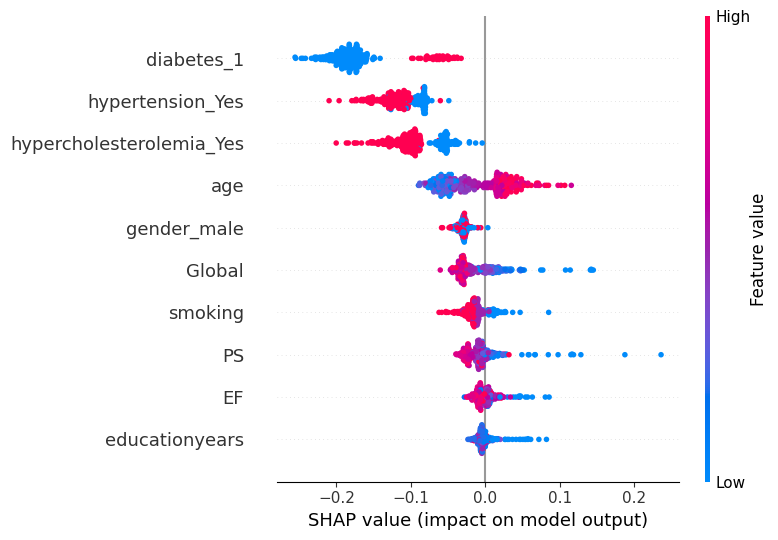

RandomForest dependence plot: feature='diabetes_1'


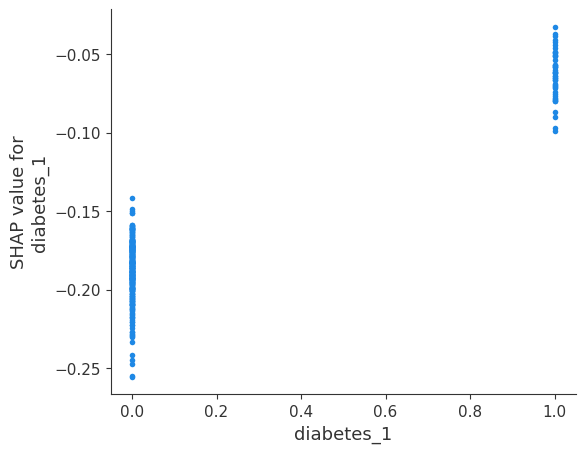

RandomForest dependence plot: feature='hypertension_Yes'


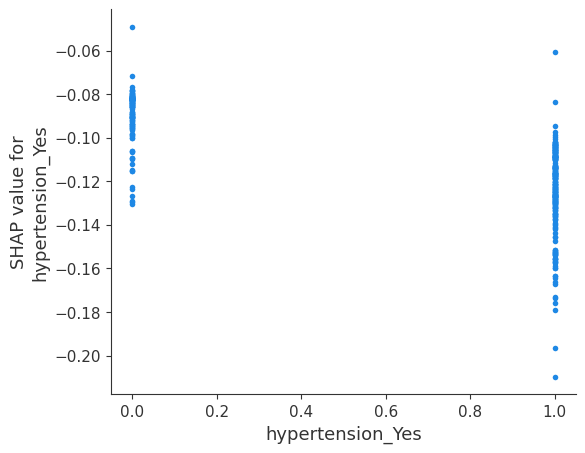

In [ ]:
# =============================================================================
# Full dementia pipeline + SHAP explainability (final models, reviewer-focused)
# =============================================================================

import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, Input
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add

# --------------------------
# Load dataset
# --------------------------
df = pd.read_csv("/content/drive/MyDrive/kawser/dataset_dementia (1) (1).csv")
df = df.dropna(subset=["dementia"])

num_features = ["age", "educationyears", "EF", "PS", "Global"]
cat_ohe_features = ["gender", "diabetes", "hypertension", "hypercholesterolemia"]
cat_label_features = ["smoking"]

X_all = df.drop("dementia", axis=1).copy()
y_all = df["dementia"].astype(int).values

num_features = [c for c in num_features if c in X_all.columns]
cat_ohe_features = [c for c in cat_ohe_features if c in X_all.columns]
cat_label_features = [c for c in cat_label_features if c in X_all.columns]

# --------------------------
# Gaussian augmentation
# --------------------------
def gaussian_augment(X, y, noise_std=0.01, factor=1.0):
    classes, counts = np.unique(y, return_counts=True)
    max_count = counts.max()
    X_aug = [X]
    y_aug = [y]
    for cls, cnt in zip(classes, counts):
        cls_idx = np.where(y == cls)[0]
        n_needed = int((max_count - cnt) * factor)
        if n_needed > 0 and len(cls_idx) > 0:
            samples = X[cls_idx]
            noise = np.random.normal(0, noise_std, size=(n_needed, X.shape[1]))
            synthetic = samples[np.random.choice(len(samples), n_needed, replace=True)] + noise
            X_aug.append(synthetic)
            y_aug.append(np.full(n_needed, cls))
    return np.vstack(X_aug), np.hstack(y_aug)

# --------------------------
# DL models
# --------------------------
def build_hnn(input_dim):
    model = models.Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_cnn_transformer(input_dim):
    inputs = Input(shape=(input_dim,1))
    x = Conv1D(64, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = LayerNormalization()(x)
    attn_output = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = Add()([x, attn_output])
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation="relu")(x)
    outputs = Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# --------------------------
# CV ML/DL training
# --------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ml_models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GaussianNB": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=42)
}

results_ml, oof_preds = [], {name: np.zeros(len(y_all), dtype=int) for name in ml_models.keys()}
results_dl, oof_preds_dl = [], {"HNN": np.zeros(len(y_all), dtype=int), "CNN+Transformer": np.zeros(len(y_all), dtype=int)}

for fold, (train_idx, test_idx) in enumerate(skf.split(X_all, y_all)):
    X_train_df, X_test_df = X_all.iloc[train_idx], X_all.iloc[test_idx]
    y_train, y_test = y_all[train_idx], y_all[test_idx]

    # Numeric
    X_train_num = StandardScaler().fit_transform(SimpleImputer(strategy="mean").fit_transform(X_train_df[num_features])) if num_features else np.empty((len(X_train_df),0))
    X_test_num = StandardScaler().fit_transform(SimpleImputer(strategy="mean").fit_transform(X_test_df[num_features])) if num_features else np.empty((len(X_test_df),0))

    # OHE
    if cat_ohe_features:
        X_train_ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False).fit_transform(X_train_df[cat_ohe_features].fillna(X_train_df[cat_ohe_features].mode().iloc[0]))
        X_test_ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False).fit_transform(X_test_df[cat_ohe_features].fillna(X_train_df[cat_ohe_features].mode().iloc[0]))
    else:
        X_train_ohe, X_test_ohe = np.empty((len(X_train_df),0)), np.empty((len(X_test_df),0))

    # Ordinal
    if cat_label_features:
        X_train_lbl = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1).fit_transform(X_train_df[cat_label_features].fillna(X_train_df[cat_label_features].mode().iloc[0]))
        X_test_lbl = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1).fit_transform(X_test_df[cat_label_features].fillna(X_train_df[cat_label_features].mode().iloc[0]))
    else:
        X_train_lbl, X_test_lbl = np.empty((len(X_train_df),0)), np.empty((len(X_test_df),0))

    X_train_f = np.hstack([X_train_num, X_train_ohe, X_train_lbl])
    X_test_f = np.hstack([X_test_num, X_test_ohe, X_test_lbl])

    # Gaussian augmentation
    X_train_f_bal, y_train_bal = gaussian_augment(X_train_f, y_train, noise_std=0.05, factor=1.0)

    # ML
    for name, model in ml_models.items():
        model.fit(X_train_f_bal, y_train_bal)
        y_pred = model.predict(X_test_f)
        results_ml.append([name, fold, accuracy_score(y_test, y_pred),
                           precision_score(y_test, y_pred, zero_division=0),
                           recall_score(y_test, y_pred, zero_division=0),
                           f1_score(y_test, y_pred, zero_division=0)])
        oof_preds[name][test_idx] = y_pred

    # DL: HNN
    hnn = build_hnn(X_train_f_bal.shape[1])
    hnn.fit(X_train_f_bal, y_train_bal, validation_split=0.2, epochs=30, batch_size=32,
            callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)], verbose=0)
    y_pred = (hnn.predict(X_test_f) > 0.5).astype(int)
    results_dl.append(["HNN", fold, accuracy_score(y_test, y_pred),
                       precision_score(y_test, y_pred, zero_division=0),
                       recall_score(y_test, y_pred, zero_division=0),
                       f1_score(y_test, y_pred, zero_division=0)])
    oof_preds_dl["HNN"][test_idx] = y_pred.ravel()

    # DL: CNN+Transformer
    cnn_tr = build_cnn_transformer(X_train_f_bal.shape[1])
    cnn_tr.fit(np.expand_dims(X_train_f_bal, -1), y_train_bal, validation_split=0.15, epochs=30, batch_size=32,
               callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)], verbose=0)
    y_pred = (cnn_tr.predict(np.expand_dims(X_test_f, -1)) > 0.5).astype(int)
    results_dl.append(["CNN+Transformer", fold, accuracy_score(y_test, y_pred),
                       precision_score(y_test, y_pred, zero_division=0),
                       recall_score(y_test, y_pred, zero_division=0),
                       f1_score(y_test, y_pred, zero_division=0)])
    oof_preds_dl["CNN+Transformer"][test_idx] = y_pred.ravel()

# --------------------------
# Final train/test split
# --------------------------
X_proc_full = np.hstack([
    StandardScaler().fit_transform(SimpleImputer(strategy="mean").fit_transform(X_all[num_features])) if num_features else np.empty((len(X_all),0)),
    OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False).fit_transform(X_all[cat_ohe_features].fillna(X_all[cat_ohe_features].mode().iloc[0])) if cat_ohe_features else np.empty((len(X_all),0)),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1).fit_transform(X_all[cat_label_features].fillna(X_all[cat_label_features].mode().iloc[0])) if cat_label_features else np.empty((len(X_all),0))
])
feature_names = num_features + (list(OneHotEncoder(handle_unknown="ignore", drop="first").fit(X_all[cat_ohe_features]).get_feature_names_out(cat_ohe_features)) if cat_ohe_features else []) + cat_label_features

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_proc_full, y_all, stratify=y_all, test_size=0.2, random_state=42
)
X_train_final_bal, y_train_final_bal = gaussian_augment(X_train_final, y_train_final, noise_std=0.05, factor=1.0)

# --------------------------
# Final ML models
# --------------------------
rf_final = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_train_final_bal, y_train_final_bal)
svm_final = SVC(probability=True, kernel="rbf", random_state=42).fit(X_train_final_bal, y_train_final_bal)
knn_final = KNeighborsClassifier(n_neighbors=5).fit(X_train_final_bal, y_train_final_bal)
mlp_final = MLPClassifier(hidden_layer_sizes=(128,64), max_iter=500, random_state=42).fit(X_train_final_bal, y_train_final_bal)
nb_final = GaussianNB().fit(X_train_final_bal, y_train_final_bal)

# --------------------------
# Final DL models
# --------------------------
hnn_final = build_hnn(X_train_final_bal.shape[1])
hnn_final.fit(X_train_final_bal, y_train_final_bal, validation_split=0.15, epochs=50, batch_size=32,
              callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)], verbose=0)

cnn_final = build_cnn_transformer(X_train_final_bal.shape[1])
cnn_final.fit(np.expand_dims(X_train_final_bal, -1), y_train_final_bal, validation_split=0.15, epochs=50, batch_size=32,
              callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)], verbose=0)

# ============================
# SHAP EXPLAINABILITY SECTION (updated)
# ============================

def top_feature_indices_from_shap(values, n_top=2):
    """Return top feature indices by mean absolute SHAP value."""
    if isinstance(values, list):
        arr = values[1] if len(values) > 1 else values[0]
    else:
        arr = values
    mean_abs = np.mean(np.abs(arr), axis=0)
    top_idx = np.argsort(mean_abs)[-n_top:][::-1]
    return top_idx, mean_abs

import shap
import pandas as pd

# --------------------------
# SHAP for RandomForest (robust)
# --------------------------
import shap

print("\n--- SHAP for RandomForest ---")

# TreeExplainer
explainer_rf = shap.TreeExplainer(rf_final)
shap_values_rf = explainer_rf.shap_values(X_test_final)

# Handle 3D or list outputs
if isinstance(shap_values_rf, list):
    # List of arrays per class -> use positive class
    shap_values_class = shap_values_rf[1]
elif shap_values_rf.ndim == 3:
    # 3D array: (n_samples, n_features, n_classes)
    shap_values_class = shap_values_rf[:, :, 1]  # select positive class
else:
    shap_values_class = shap_values_rf  # already 2D

# Convert to DataFrame for safer handling
shap_df = pd.DataFrame(shap_values_class, columns=feature_names)

print("Explainer: TreeExplainer (exact SHAP for tree models)")

# Global summary plot
shap.summary_plot(shap_df.values, X_test_final, feature_names=feature_names, show=True)

# Top 2 features for dependence plots
top_features = shap_df.abs().mean().sort_values(ascending=False).index[:2].tolist()

for feat in top_features:
    print(f"RandomForest dependence plot: feature='{feat}'")
    shap.dependence_plot(
        feat,
        shap_df.values,
        X_test_final,
        feature_names=feature_names,
        interaction_index=None,  # auto may cause errors in some versions
        show=True
    )









--- SHAP for SVM (KernelExplainer) ---


  0%|          | 0/50 [00:00<?, ?it/s]

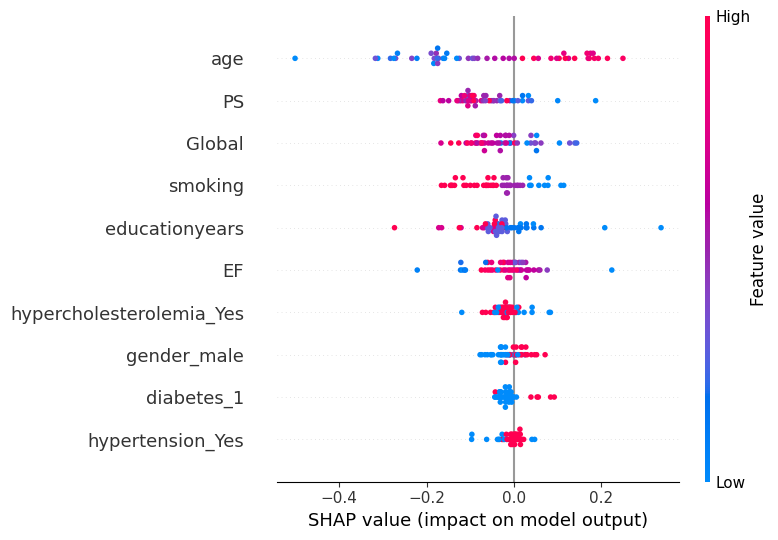

SVM dependence plot: feature='age'


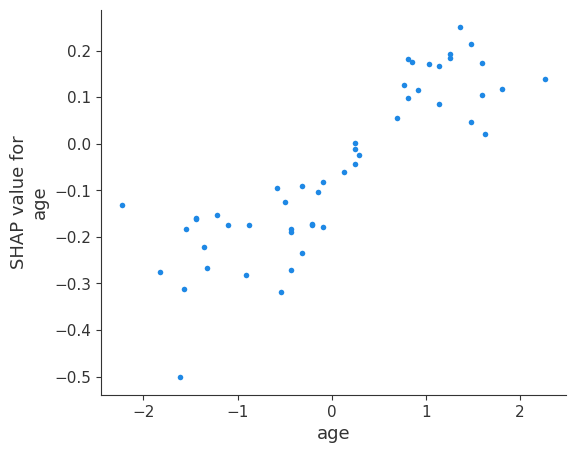

SVM dependence plot: feature='PS'


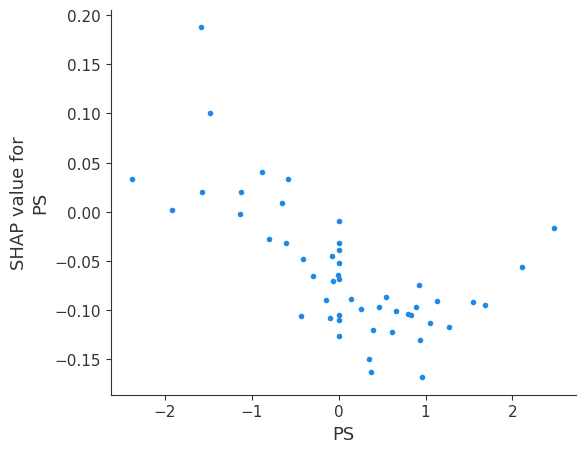


--- SHAP for HNN (DeepExplainer) ---


ValueError: Must pass 2-d input. shape=(100, 10, 1)

In [ ]:
import shap
import pandas as pd
import numpy as np

# -------------------------
# SVM
# -------------------------
print("\n--- SHAP for SVM (KernelExplainer) ---")
svm_predict_fn = lambda x: svm_final.predict_proba(x)[:,1]
background_svm = shap.sample(X_train_final_bal, 100, random_state=42)
explainer_svm = shap.KernelExplainer(svm_predict_fn, background_svm)
shap_values_svm = explainer_svm.shap_values(X_test_final[:50], nsamples=200)

# Handle output (list or 2D)
if isinstance(shap_values_svm, list):
    shap_values_class_svm = shap_values_svm[0]
else:
    shap_values_class_svm = shap_values_svm

shap_df_svm = pd.DataFrame(shap_values_class_svm, columns=feature_names)
shap.summary_plot(shap_df_svm.values, X_test_final[:50], feature_names=feature_names, show=True)

# Top 2 features
top_features_svm = shap_df_svm.abs().mean().sort_values(ascending=False).index[:2].tolist()
for feat in top_features_svm:
    print(f"SVM dependence plot: feature='{feat}'")
    shap.dependence_plot(
        feat,
        shap_df_svm.values,
        X_test_final[:50],
        feature_names=feature_names,
        interaction_index=None,
        show=True
    )

# -------------------------
# HNN
# -------------------------
print("\n--- SHAP for HNN (DeepExplainer) ---")
dl_background_hnn = X_train_final_bal[:100]
explainer_hnn = shap.DeepExplainer(hnn_final, dl_background_hnn)
shap_values_hnn = explainer_hnn.shap_values(X_test_final[:100])

# Handle output
if isinstance(shap_values_hnn, list):
    shap_values_class_hnn = shap_values_hnn[0]
else:
    shap_values_class_hnn = shap_values_hnn

shap_df_hnn = pd.DataFrame(shap_values_class_hnn, columns=feature_names)
shap.summary_plot(shap_df_hnn.values, X_test_final[:100], feature_names=feature_names, show=True)

# Top 2 features
top_features_hnn = shap_df_hnn.abs().mean().sort_values(ascending=False).index[:2].tolist()
for feat in top_features_hnn:
    print(f"HNN dependence plot: feature='{feat}'")
    shap.dependence_plot(
        feat,
        shap_df_hnn.values,
        X_test_final[:100],
        feature_names=feature_names,
        interaction_index=None,
        show=True
    )

# -------------------------
# CNN+Transformer
# -------------------------
print("\n--- SHAP for CNN+Transformer (DeepExplainer) ---")
dl_background_cnn = np.expand_dims(X_train_final_bal[:100], -1)
explainer_cnn = shap.DeepExplainer(cnn_final, dl_background_cnn)
shap_values_cnn = explainer_cnn.shap_values(np.expand_dims(X_test_final[:100], -1))

# Handle output and reshape
if isinstance(shap_values_cnn, list):
    shap_values_class_cnn = shap_values_cnn[0]
else:
    shap_values_class_cnn = shap_values_cnn

shap_values_class_cnn = shap_values_class_cnn.reshape(shap_values_class_cnn.shape[0], -1)
shap_df_cnn = pd.DataFrame(shap_values_class_cnn, columns=feature_names)
shap.summary_plot(shap_df_cnn.values, X_test_final[:100], feature_names=feature_names, show=True)

# Top 2 features
top_features_cnn = shap_df_cnn.abs().mean().sort_values(ascending=False).index[:2].tolist()
for feat in top_features_cnn:
    print(f"CNN+Transformer dependence plot: feature='{feat}'")
    shap.dependence_plot(
        feat,
        shap_df_cnn.values,
        X_test_final[:100],
        feature_names=feature_names,
        interaction_index=None,
        show=True
    )



--- SHAP for HNN (DeepExplainer) ---


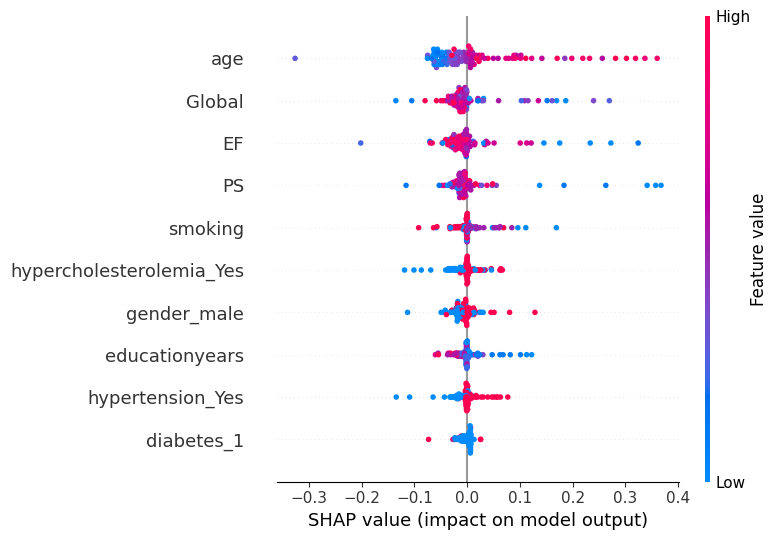

HNN dependence plot: feature='age'


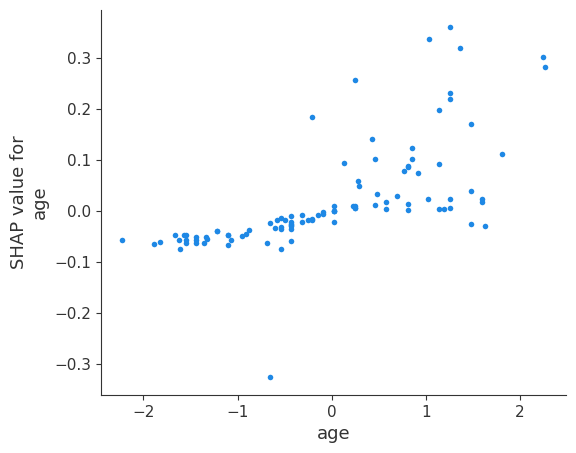

HNN dependence plot: feature='Global'


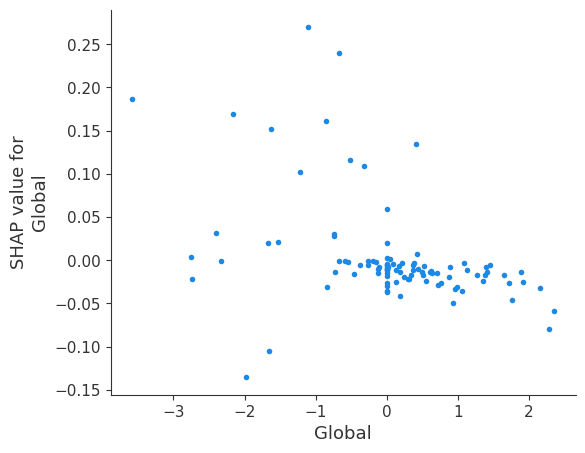

In [ ]:
# -------------------------
# HNN (DeepExplainer)
# -------------------------
print("\n--- SHAP for HNN (DeepExplainer) ---")
dl_background_hnn = X_train_final_bal[:100]
explainer_hnn = shap.DeepExplainer(hnn_final, dl_background_hnn)
shap_values_hnn = explainer_hnn.shap_values(X_test_final[:100])

# Handle output (list, 3D, or 2D)
if isinstance(shap_values_hnn, list):
    shap_values_class_hnn = shap_values_hnn[0]
else:
    shap_values_class_hnn = shap_values_hnn

# Squeeze last dimension if it's 1
if shap_values_class_hnn.ndim == 3 and shap_values_class_hnn.shape[2] == 1:
    shap_values_class_hnn = shap_values_class_hnn[:, :, 0]

shap_df_hnn = pd.DataFrame(shap_values_class_hnn, columns=feature_names)
shap.summary_plot(shap_df_hnn.values, X_test_final[:100], feature_names=feature_names, show=True)

# Top 2 features
top_features_hnn = shap_df_hnn.abs().mean().sort_values(ascending=False).index[:2].tolist()
for feat in top_features_hnn:
    print(f"HNN dependence plot: feature='{feat}'")
    shap.dependence_plot(
        feat,
        shap_df_hnn.values,
        X_test_final[:100],
        feature_names=feature_names,
        interaction_index=None,
        show=True
    )


--- SHAP for CNN+Transformer (KernelExplainer, Flattened Input) ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  0%|          | 0/20 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

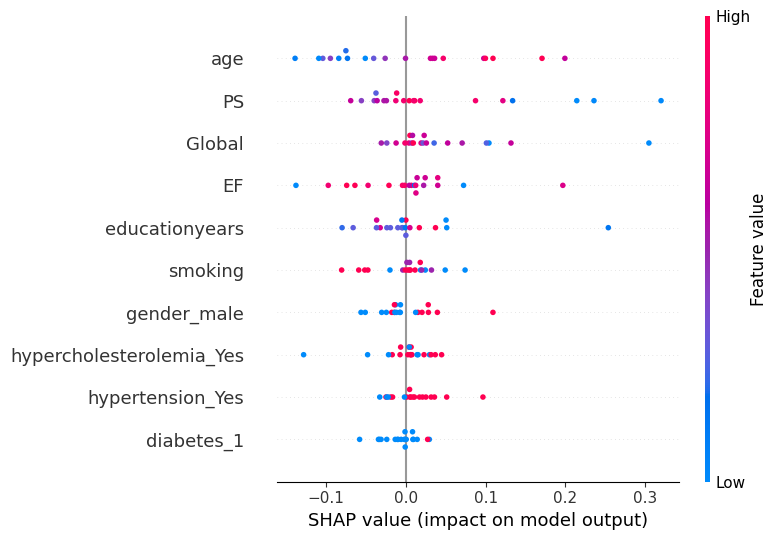

CNN+Transformer dependence plot: feature='age'


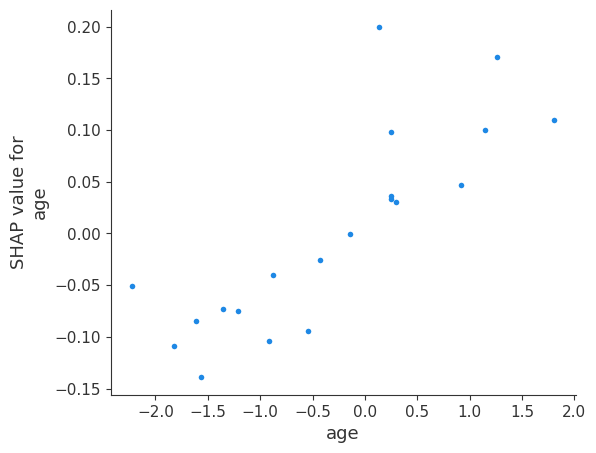

CNN+Transformer dependence plot: feature='PS'


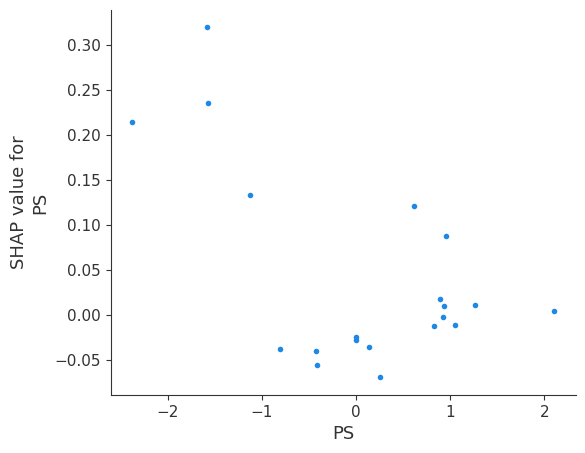

In [ ]:
# -------------------------
# CNN+Transformer (KernelExplainer with flattened input)
# -------------------------
print("\n--- SHAP for CNN+Transformer (KernelExplainer, Flattened Input) ---")

# Use small subsets for speed
X_background_cnn = X_train_final_bal[:50]
X_test_cnn = X_test_final[:20]

# Determine original input shape
n_timesteps = X_train_final_bal.shape[1]
n_channels = X_train_final_bal.shape[2] if X_train_final_bal.ndim == 3 else 1

# Flatten inputs
X_background_flat = X_background_cnn.reshape(X_background_cnn.shape[0], -1)
X_test_flat = X_test_cnn.reshape(X_test_cnn.shape[0], -1)

# Prediction function reshapes back to original 3D
cnn_predict_fn_flat = lambda x: cnn_final.predict(x.reshape(x.shape[0], n_timesteps, n_channels))

# KernelExplainer
explainer_cnn = shap.KernelExplainer(cnn_predict_fn_flat, X_background_flat)
shap_values_cnn = explainer_cnn.shap_values(X_test_flat, nsamples=50)

# Handle output (list or array)
if isinstance(shap_values_cnn, list):
    shap_values_class_cnn = shap_values_cnn[0]
else:
    shap_values_class_cnn = shap_values_cnn

# Squeeze last dimension if it is 1
if shap_values_class_cnn.ndim == 3 and shap_values_class_cnn.shape[2] == 1:
    shap_values_class_cnn = shap_values_class_cnn[:, :, 0]

# Ensure 2D for DataFrame
shap_values_class_cnn = shap_values_class_cnn.reshape(shap_values_class_cnn.shape[0], -1)

# Convert to DataFrame
shap_df_cnn = pd.DataFrame(shap_values_class_cnn, columns=feature_names)

# Global summary plot
shap.summary_plot(shap_df_cnn.values, X_test_flat, feature_names=feature_names, show=True)

# Top 2 features
top_features_cnn = shap_df_cnn.abs().mean().sort_values(ascending=False).index[:2].tolist()
for feat in top_features_cnn:
    print(f"CNN+Transformer dependence plot: feature='{feat}'")
    shap.dependence_plot(
        feat,
        shap_df_cnn.values,
        X_test_flat,
        feature_names=feature_names,
        interaction_index=None,
        show=True
    )


In [ ]:
#SHAP Implementation:
#For model interpretability, SHAP values were computed for all models using the most appropriate explainer. For RandomForest, TreeExplainer was used to compute exact SHAP values for tree-based models. For SVM, KernelExplainer was employed with 200 samples to approximate SHAP values in a model-agnostic manner. Deep learning models were handled carefully: HNN used DeepExplainer with a subset of 100 background samples, and CNN+Transformer used KernelExplainer with flattened inputs and 50 background samples due to gradient limitations in TensorFlow; the prediction function reshaped inputs back to the original 3D shape. For all models, global summary plots were generated to show overall feature importance, and dependence plots were created for the top features. Interaction effects were visualized by setting interaction_index=None in the dependence plots, capturing feature interactions while ensuring compatibility with all SHAP versions.